<a href="https://colab.research.google.com/github/yuuki-kusumoto/kusumoto/blob/main/BERT_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
po = "ポジ"
ne = "ネガ"

po = tokenizer_512(po)
ne = tokenizer_512(ne)

po_to = torch.LongTensor(po).unsqueeze(0)
print(po_to)
ne_to = torch.LongTensor(ne).unsqueeze(0)
print(ne_to)

positive_bert = BERT_net(po_to)
negative_bert = BERT_net(ne_to)
posi_bert = positive_bert[:, 1, :]
nega_bert = negative_bert[:, 1, :]
posi_bert.shape

In [1]:
!nvidia-smi

Fri Nov  5 16:45:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    47W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install MeCab
!pip install mecab-python3
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.9)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.16)
xz-utils is already installed at the requested version (5.2.2-1.3)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already instal

In [3]:
import subprocess

cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')

In [4]:
!pip install ipadic
!pip install mecab-python3
!pip install unidic-lite
# MeCabとtransformersを用意する
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
# 以下で報告があるようにmecab-python3のバージョンを0.996.5にしないとtokezerで落ちる
# https://stackoverflow.com/questions/62860717/huggingface-for-japanese-tokenizer
!pip install mecab-python3==0.996.5
!pip install unidic-lite # これないとMeCab実行時にエラーで落ちる
!pip install transformers
!pip install "transformers==2.5.1"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
aptitude is already the newest version (0.8.10-6ubuntu1).
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already installed at the requested version (2.7.0-20070801+main-1)
git is already installed at the requested version (1:2.17.1-1ubuntu0.9)
make is already installed at the requested version (4.1-9.1ubuntu1)
curl is already installed at the requested version (7.58.0-2ubuntu3.16)
xz-utils is already installed at the requested version (5.2.2-1.3)
file is already installed at the requested version (1:5.32-2ubuntu0.4)
mecab is already installed at the requested version (0.996-5)
libmecab-dev is already installed at the requested version (0.996-5)
mecab-ipadic-utf8 is already instal

In [5]:
import torch
import transformers
from transformers.modeling_bert import BertModel
from transformers.tokenization_bert_japanese import BertJapaneseTokenizer
from transformers import BertJapaneseTokenizer, BertForMaskedLM

# パッケージのimport
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
import torchtext

# 必要なパッケージのimport
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext


! curl http://www.cl.ecei.tohoku.ac.jp/resources/sent_lex/pn.csv.m3.120408.trim > pn.csv


model = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

# model_nameはここから取得(cf. https://huggingface.co/transformers/pretrained_models.html)
model_name = "cl-tohoku/bert-base-japanese"
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  676k  100  676k    0     0  1168k      0 --:--:-- --:--:-- --:--:-- 1166k


In [6]:
# ファイルをオープンして、1行ずつその内容を読み込んで処理する
with open('train_data.txt') as f:
    for line in f:
        line = line.rstrip()  # 読み込んだ行の末尾には改行文字があるので削除
        print(line)
        
with open('train_data.txt') as f:
  texts = f.read()

#訓練データをリストにして開く

with open('train_data.txt', 'r') as f:
    tr_list = f.read().split("\n")

#訓練データをラベルと文章に分けてリストに入れる。

tr_word = []
tr_label = []

for i in range(0,4000):
  a = tr_list[i]
  b = a.replace('\t','')

  tr_word.append(b[1:len(b)])
  tr_label.append(b[0])

print(tr_word)
print(tr_label)

1	駅前に立地しており非常に便利、車利用でしたが地下駐車場で助かりました。大和ミュージアムや海上自衛隊呉史料館の見学にも最適です！
1	（移転前の）広島球場、市内のバスターミナル、原爆ドームすべてに近く、野球観戦＆観光がとても効率よくできました。ホテルの前から市電で乗り換えなく宮島まで行かれるのもポイントが高いです。ホテルの中は一般的なビジネスホテルで、部屋は広くはないですが、狭くて困る、というわけでもありませんし、バスルームも含めて清潔でした。ケーブルテレビも見られました。
1	なんといっても大浴場！気持ちがいいです。名物？の夜鳴きそばもおいしくいただきました。朝食付で料金も手ごろです。
1	駅や繁華街からは遠いですが、原爆ドームなどには近いので、朝から観光に回るには最適でした。やはり観光ではよく歩くので、疲れた脚には大浴場でのんびりできるのが最高でした。大浴場は他のドーミーインに比べると普通の大浴場ですが、清潔でした。また利用しませんでしたが、駅との無料送迎があったようで、バスで広島駅まで送ってもらえます。
1	ビジネスホテルには珍しく大浴場があり、お部屋は狭かったのですが、疲れはとれました。お夜食に夜鳴きそばというものを出してくれるサービスがあり、主人も気に入った様子でした。
1	初めてドーミーインに泊まりました。噂には聞いていましたが、かなりの充実度に驚かされました。最上階にあるスパは、有料の銭湯よりもよっぽど充実していて、感動しました。サラリーマンがビジネスユースで使うにはピッタリです。ホテルの施設はホントに普通ですが、夜中に軽食として出される「夜鳴きそば」なる名物にも驚き。結構おいしかったです。また泊まりたいと思いました。
1	年末にここを利用しました。近くには美味しいレストランが多いこと、平和大通りに面しているので夜のイルミネーションをゆっくり楽しむことができます。大浴場がついているので、狭いお風呂が苦手な方にもぴったり。共同の洗濯機があり（洗剤もついている）長期滞在の方にもオススメです。
1	きれいな施設。電車までは徒歩、原爆ドーム・平和記念公園までも徒歩で行ける！部屋はきれいでアメニティもそろっている。上の階では洗濯機も使えてとても満足。なんといっても温泉付きなので疲れた身体を休めれて良かった。ロビーにはインターネット接続のパソコンが２台あり。また

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [252]:
with open('test_data.txt') as f:
  texts = f.read()
  
#テストデータをリストにして開く

with open('test_data.txt', 'r') as f:
    ts_list = f.read().split("\n")

#テストデータをラベルと文章に分けてリストに入れる。

ts_word = []
ts_label = []

for i in range(0,2000):
  a = ts_list[i]
  b = a.replace('\t','')

  ts_word.append(b[1:len(b)])
  ts_label.append(b[0])

print(ts_word)
print(ts_label)

['朝６時台の飛行機に乗るために、空港からのアクセスがいいこのホテルに泊まりました。空港からリムジンバスで２０分くらいなので、たいへん便利でした。周りには大型スーパーもあり、買い出しもできました。予想外の収穫はホテル内にあるレストランがけっこうおいしかったということです（フェアでスペアリブをやっていてそれが「当たり」でした）。', '連泊しました。今まで、連泊するときは、歯ブラシを取り替えてくれないホテルばかりでした。今回、母と２人で宿泊しました。同じ色だったので、違う色にしてくれれば・・・と思っていました。でも、翌日に新しい歯ブラシが用意してありました。小さなことかもしれませんが、心配りに感謝します。でも、今はエコの時代。ツインで宿泊するときは、違う色にしてくれれば、同じ歯ブラシでも構いませんよ', '4月1日から4日まで小学生の子ども2人を連れて東京へ旅行に行ってきました。ディズニーリゾートやお台場に行きたいということで、選んだホテルはベッドが3つ用意できるハートンホテルでした。ツインのベッドにエキストラベッドを入れた部屋でしたが、それでもそこそこ広く、値段も連泊割引からさらに会員割引（期間限定）も使え、3泊で29,600円でした。近くにはジャスコもあり、もちろんディズニーリゾートやお台場にも便利にいけてお勧めのホテルでした。', 'かなり混む時期に予約をしましたが、TDLにいくのもさほど遠くなく、快適に過ごせました。景色のいいお部屋にしていただいてとても満足です。近くにジャスコがあるのが便利でした。料金的にもリーズナブルで、次回も利用させていただこうと思っています。<br/>欲を言えば・・・添い寝の子供にもタオルがほしかったですね。<br/><br/>宿からの回答:<br/>この度は、当ホテルをご利用頂き誠にありがとうございます。 <br/>タオルに関しては、フロントにご連絡いただければ、すぐにお部屋にお持ちいたします。<br/>今後も快適にお過ごし頂けるように努めてまいりますので、ハートンホテル東品川を宜しくお願い致します。 <br/>またのご利用お待ちしております。 <br/>宿泊課:木嶋', '駅の目の前の好立地で、部屋もキレイで新しく金額も安いので気に入りました。また、利用したいです。<br/><br/>宿からの回答:<br/>この度は、当ホテルに宿泊

In [253]:
#フレームに
import pandas as pd

#text, indexの順番にする
tr_df1 = pd.DataFrame({'tr_word' : tr_word, 'tr_label' : tr_label})
len(tr_df1)

4000

In [254]:
#フレームに
import pandas as pd

ts_df = pd.DataFrame({'tr_word' : ts_word, 'tr_label' : ts_label})
len(ts_df)

2000

In [369]:
tr_df = pd.concat([tr_df1, ts_df])
print(len(tr_df))
tr_df = tr_df.sample(frac=1, random_state=127).reset_index(drop=True)
tr_df.shape

6000


(6000, 2)

In [370]:
tr_df

,tr_word,tr_label
0,団体客として初めて利用させてもらったが、あまりのホテル側の態度の悪さ（特に受付にいた初老の...,0
1,夜中まで上の階の音がうるさくてぜんぜん眠れない。ギシギシ、ミシミシゆれるような音がずっとして...,0
2,とにかく部屋が広い！今回家族３人で宿泊しましたが、ベッド３台が入っても余裕の広さです。投稿写...,1
3,みなとみらいに位置し、部屋からの眺めは最高でしたが、サービスは中流以下のホテル。結婚披露宴に...,0
4,宮島までのアクセスは宮島口駅下車→(徒歩５分)→連絡船乗り場から船で宮島桟橋まで１０分。桟橋...,0
...,...,...
5995,博多の天神か呉服町から歩くと相当ある。国際会議場へは近いがそれ以外は使いにくい。新館とあるが...,0
5996,用事で広島まで行く事になったので、クチコミを参考にこのホテルに決めました。ホテルのホームペー...,1
5997,ここは結婚式もできるシティーホテル。広島のど真ん中に位置するため、如何せん便利だけど高い！Ａ...,1
5998,広島駅から徒歩5分程度で交通のアクセスが便利。広島の繁華街である八丁堀付近までは徒歩15分ほ...,1


In [402]:
# tsvファイルで保存する
#tr_df = tr_df[:100]
# 全体の2割の文章数
len_0_2 = len(tr_df) // 5

# 前から2割をテストデータとする
tr_df[:len_0_2].to_csv("./test.tsv", sep='\t', index=False, header=None)
print(tr_df[:len_0_2].shape)

# 前2割からを訓練&検証データとする
tr_df[len_0_2:].to_csv("./train.tsv", sep='\t', index=False, header=None)
print(tr_df[len_0_2:].shape)

(1200, 2)
(4800, 2)


In [372]:
def tokenizer_512(input_text):
    """torchtextのtokenizerとして扱えるように、512単語のpytorchでのencodeを定義。ここで[0]を指定し忘れないように"""
    return tokenizer.encode(input_text, max_length=512, return_tensors='pt')[0]


TEXT = torchtext.legacy.data.Field(sequential=True, tokenize=tokenizer_512, use_vocab=False, lower=False,include_lengths=True, batch_first=True, fix_length=512, pad_token=0)
# 注意：tokenize=tokenizer.encodeと、.encodeをつけます。padding[PAD]のindexが0なので、0を指定します。

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

# 各tsvファイルを読み込み、分かち書きをしてdatasetにします
# 少し時間がかかります
# train_eval：4511個、test：1127個

dataset_train_eval, dataset_test = torchtext.legacy.data.TabularDataset.splits(
    path='.', train='train.tsv', test='test.tsv', format='tsv', fields=[('Text', TEXT), ('Label', LABEL)])

In [373]:
# torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
# train_eval：4000個、test：2000個

dataset_train, dataset_eval = dataset_train_eval.split(
    split_ratio = 1 - 0.25, random_state=random.seed(1234))

# datasetの長さを確認してみる
print(dataset_train.__len__())
print(dataset_eval.__len__())
print(dataset_test.__len__())

3600
1200
1200


In [374]:
# 乱数シードの固定

import os
import random
import numpy as np
import torch

SEED_VALUE = 1234  # これはなんでも良い
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)  # PyTorchを使う場合

# torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
# train_eval：4000個、test：2000個

dataset_train, dataset_eval = dataset_train_eval.split(
    split_ratio = 1 - 0.25, random_state=random.seed(1234))

# datasetの長さを確認してみる
print(dataset_train.__len__())
print(dataset_eval.__len__())
print(dataset_test.__len__())

# datasetの中身を確認してみる
item = next(iter(dataset_train))
print(item.Text)
print("長さ：", len(item.Text))  # 長さを確認 [CLS]から始まり[SEP]で終わる。512より長いと後ろが切れる
print("ラベル：", item.Label)

3600
1200
1200
tensor([    2,  8359,   235, 18177,  1285,    40,  8962,    48,   155,  7308,
            8,  6777,     9,   340, 28482, 28933, 28449,  4818,  2992,     8,
         3250,     9,  3038,    47, 28506,  2992,    14, 20505,     5,   120,
            9, 28285,    16,  2610,     8,  2449,  2638,    14,  3719,   947,
         3452,    28,   515,  2087,  2992,     8,  3225,     9,   427, 28781,
           18,   947,  5218, 28588,  5929,     9,  5735,    80,  2992,     8,
            3])
長さ： 61
ラベル： 0


In [375]:
# DataLoaderを作成

batch_size = 128

dl_train = torchtext.legacy.data.Iterator(
    dataset_train, batch_size=batch_size, train=True)

dl_eval = torchtext.legacy.data.Iterator(
    dataset_eval, batch_size=batch_size, train=False, sort=False)

dl_test = torchtext.legacy.data.Iterator(
    dataset_test, batch_size=batch_size, train=False, sort=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": dl_train, "val": dl_eval}

In [376]:
from torch import nn

class BertForReview(nn.Module):
    '''BERTモデルにレビュー文の2クラスを判定する部分をつなげたモデル'''

    def __init__(self):
        super(BertForReview, self).__init__()

        # BERTモジュール
        self.bert = model  # 日本語学習済みのBERTモデル

        # headにポジネガ予測を追加
        # 入力はBERTの出力特徴量の次元768、出力は14クラス
        #cls層の追加
        self.cls = nn.Linear(in_features=768, out_features=2)

        
        # 重み初期化処理
        nn.init.normal_(self.cls.weight, std=0.02)
        nn.init.normal_(self.cls.bias, 0)
    
    
    def forward(self, input_ids):
        '''
        input_ids： [batch_size, sequence_length]の文章の単語IDの羅列
        '''

        # BERTの基本モデル部分の順伝搬
        # 順伝搬させる
        #print("input_ids :", input_ids)
        result = self.bert(input_ids)  # reult は、sequence_output, pooled_output

        # sequence_outputの先頭の単語ベクトルを抜き出す
        vec_0 = result[0]  # 最初の0がsequence_outputを示す
        vec_02 = vec_0[:, 0, :]  # 全バッチ。先頭0番目の単語の全768要素。　つまりclsトークンを獲得している。
        vec_02 = vec_02.view(-1, 768)  # sizeを[batch_size, hidden_size]
        vec_03 = vec_0[:, 0:512, :]
        output = self.cls(vec_02)  # 全結合層
        m = nn.Sigmoid()
        out = m(output)

        return vec_02, vec_03

#モデル構築
BERT_net = BertForReview()

print('ネットワーク設定完了')

# 勾配計算を最後のBertLayerモジュールと追加した分類アダプターのみ実行

# 1. まず全部を、勾配計算Falseにしてしまう
for param in BERT_net.parameters():
    param.requires_grad = False

# 2. BertLayerモジュールの最後を勾配計算ありに変更
for param in BERT_net.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

# 3. 識別器を勾配計算ありに変更
for param in BERT_net.cls.parameters():
    param.requires_grad = True

ネットワーク設定完了


In [377]:
from torch import nn

class BertForReview(nn.Module):
    '''BERTモデルにレビュー文の2クラスを判定する部分をつなげたモデル'''

    def __init__(self):
        super(BertForReview, self).__init__()

        # BERTモジュール
        self.bert = model  # 日本語学習済みのBERTモデル

        # headにポジネガ予測を追加
        # 入力はBERTの出力特徴量の次元768、出力は14クラス
        #cls層の追加
        self.cls = nn.Linear(in_features=768, out_features=2)

        
        # 重み初期化処理
        nn.init.normal_(self.cls.weight, std=0.02)
        nn.init.normal_(self.cls.bias, 0)
    
    
    def forward(self, input_ids):
        '''
        input_ids： [batch_size, sequence_length]の文章の単語IDの羅列
        '''

        # BERTの基本モデル部分の順伝搬
        # 順伝搬させる
        #print("input_ids :", input_ids)
        result = self.bert(input_ids)  # reult は、sequence_output, pooled_output

        # sequence_outputの先頭の単語ベクトルを抜き出す
        vec_0 = result[0]  # 最初の0がsequence_outputを示す
        vec_02 = vec_0[:, 0, :]  # 全バッチ。先頭0番目の単語の全768要素。　つまりclsトークンを獲得している。
        vec_02 = vec_02.view(-1, 768)  # sizeを[batch_size, hidden_size]
        vec_03 = vec_0[:, 0:512, :]
        output = self.cls(vec_02)  # 全結合層
        m = nn.Sigmoid()
        out = m(output)

        return vec_02, vec_03

#モデル構築
BERT_net = BertForReview()

print('ネットワーク設定完了')

# 勾配計算を最後のBertLayerモジュールと追加した分類アダプターのみ実行

# 1. まず全部を、勾配計算Falseにしてしまう
for param in BERT_net.parameters():
    param.requires_grad = False

# 2. BertLayerモジュールの最後を勾配計算ありに変更
for param in BERT_net.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

# 3. 識別器を勾配計算ありに変更
for param in BERT_net.cls.parameters():
    param.requires_grad = True

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext

class PositionalEncoder(nn.Module):
    '''入力された単語の位置を示すベクトル情報を付加する'''

#max_seq_len はパディングしないといけない？
    def __init__(self, d_model=768, max_seq_len=512):
        super().__init__()

        self.d_model = d_model  # 単語ベクトルの次元数

        # 単語の順番（pos）と埋め込みベクトルの次元の位置（i）によって一意に定まる値の表をpeとして作成
        pe = torch.zeros(max_seq_len, d_model)
        #print(pe)

        # GPUが使える場合はGPUへ送る
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        pe = pe.to(device)

        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos /
                                          (10000 ** ((2 * (i + 1))/d_model)))

        # 表peの先頭に、ミニバッチ次元となる次元を足す
        self.pe = pe.unsqueeze(0)

        # 勾配を計算しないようにする
        self.pe.requires_grad = False

    def forward(self, x):

        # 入力xとPositonal Encodingを足し算する
        # xがpeよりも小さいので、大きくする
        ret = math.sqrt(self.d_model)*x + self.pe
        return ret


class Attention(nn.Module):
    '''シングルAttentionで実装'''

    def __init__(self, d_model=768):
        super().__init__()

        # SAGANでは1dConvを使用したが、今回は全結合層で特徴量を変換する
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)

        # 出力時に使用する全結合層
        self.out = nn.Linear(d_model, d_model)

        # Attentionの大きさ調整の変数
        self.d_k = d_model

    def forward(self, cls_tokens, pe):
      #mask = torch.zeros(768)
      #for i in range(0, len(cls_tokens)):
        
        # 全結合層で特徴量を変換
        k = self.k_linear(pe)
        q = self.q_linear(cls_tokens)
        v = self.v_linear(pe)

        # Attentionの値を計算する
        # 各値を足し算すると大きくなりすぎるので、root(d_k)で割って調整
        
        #attention_weights = torch.matmul(q, k.transpose(2, 1)) / math.sqrt(self.d_k)

        attention_weights = torch.matmul(q.unsqueeze(1), k.transpose(2, 1) )/ math.sqrt(self.d_k)



        # ここでmaskを計算
        #mask = mask.unsqueeze(1)
        #attention_weights = attention_weights.masked_fill(mask == 0, -1e9)

        # softmaxで規格化をする
        normlized_weights = F.softmax(attention_weights, dim=-1)

        # AttentionをValueとかけ算
        output = torch.matmul(normlized_weights, v)

        # 全結合層で特徴量を変換
        output = self.out(output)
        

        return output, normlized_weights


class FeedForward(nn.Module):
    def __init__(self, d_model = 768, d_ff=1024, dropout=0.1):
        '''Attention層から出力を単純に全結合層2つで特徴量を変換するだけのユニットです'''
        super().__init__()

        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.dropout(F.relu(x))
        x = self.linear_2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, d_model=768, dropout=0.1):
        super().__init__()

        # LayerNormalization層
        self.norm_1 = nn.LayerNorm(d_model)
        self.norm_2 = nn.LayerNorm(d_model)

        # Attention層
        self.attn = Attention(d_model)

        # Attentionのあとの全結合層2つ
        self.ff = FeedForward(d_model)

        # Dropout
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, pn, x):
        # PositionalEncoding を行った後に正規化する
        x_normlized = self.norm_1(x)

        output, normlized_weights = self.attn(pn, x_normlized)
        #FeedForward層の入力作成
        x2 = x + self.dropout_1(output)

        # 正規化と全結合層
        x_normlized2 = self.norm_2(x2)
        output = x2 + self.dropout_2(self.ff(x_normlized2))

        return output, normlized_weights

class ClassificationHead(nn.Module):
    '''Transformer_Blockの出力を使用し、最後にクラス分類させる'''

    def __init__(self, d_model=768, output_dim=2):
        super().__init__()

        # 全結合層
        self.linear = nn.Linear(d_model, output_dim)  # output_dimはポジ・ネガの2つ

        # 重み初期化処理
        nn.init.normal_(self.linear.weight, std=0.02)
        nn.init.normal_(self.linear.bias, 0)

    def forward(self, x):
        x0 = x[:, 0, :]  # 各ミニバッチの各文の cls の特徴量（768次元）を取り出す
        out = self.linear(x0)

        return out
        
# 最終的なTransformerモデルのクラス


class TransformerClassification(nn.Module):
    '''Transformerでクラス分類させる'''

    def __init__(self,  d_model=768, max_seq_len=512, output_dim=2):
        super().__init__()

        # モデル構築
        
        self.net1 = BERT_net
        self.net2 = PositionalEncoder(d_model=d_model, max_seq_len=max_seq_len)
        self.net3_1 = TransformerBlock(d_model=d_model)
        #self.net3_2 = TransformerBlock(d_model=d_model)
        self.net4 = ClassificationHead(output_dim=output_dim, d_model=d_model)

    def forward(self, text):

        cls, x1 = self.net1(text)

        x2 = self.net2(x1)  # Positon情報を足し算
        
        x3_1, normlized_weights_1 = self.net3_1(cls, x2)  # Self-Attentionで特徴量を変換
        
        #x3_2, normlized_weights_2 = self.net3_2(x3_1, mask)  # Self-Attentionで特徴量を変換
        
        x4 = self.net4(x3_1)  # 最終出力の0単語目を使用して、分類0-1のスカラーを出力
        
        return x4, normlized_weights_1 #, normlized_weights_2

ネットワーク設定完了


In [378]:
# モデル構築
TC_net = TransformerClassification()
    
# ネットワークの初期化を定義
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        # Liner層の初期化
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

# 訓練モードに設定
TC_net.train()

# TransformerBlockモジュールを初期化実行
TC_net.net3_1.apply(weights_init)
#TC_net.net3_2.apply(weights_init)
print('ネットワーク設定完了')

# 損失関数の設定
criterion = nn.CrossEntropyLoss()
# nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

# 最適化手法の設定
learning_rate = 2e-5
optimizer = optim.Adam(TC_net.parameters(), lr=learning_rate)

ネットワーク設定完了


In [380]:
# モデルを学習させる関数を作成

def train_model(tc_net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')
    # ネットワークをGPUへ
    #bert_net.to(device)
    tc_net.to(device)

    train_loss = []
    val_loss = []

    acc_train_list = []
    acc_val_list = []



    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    for epoch in range(num_epochs):

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:

            if phase == 'train':
                #bert_net.train()  # モデルを訓練モードに
                tc_net.train()
            else:
                #bert_net.eval()   # モデルを検証モードに
                tc_net.eval()


            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書オブジェクト

                # GPUが使えるならGPUにデータを送る
                inputs = batch.Text[0].to(device)  # 文章
                labels = batch.Label.to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()

                #BERTに入力
                #cls_tokens, bert_tokens  = bert_net(inputs)


                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):


                    # Transformerに入力
                    outputs, weights  = tc_net(inputs)
                    
                    loss = criterion(outputs, labels)  # 損失を計算

                    _, preds = torch.max(outputs, 1)  # ラベルを予測（dim=1 列方向のＭａｘを取得、predsは最大のindex）

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()   #損失の計算
                        optimizer.step()  # 勾配の更新


                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            if phase == 'train':
              train_loss = np.append(train_loss, epoch_loss)
              acc_train_list = np.append(acc_train_list, epoch_acc.cpu().numpy())

            else:
              val_loss = np.append(val_loss, epoch_loss)
              acc_val_list = np.append(acc_val_list, epoch_acc.cpu().numpy())

            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))


    return tc_net, train_loss, val_loss, acc_train_list, acc_val_list


In [381]:
len(dataloaders_dict["train"].dataset)

3600

In [382]:
#訓練データ数 3600, #バリデーションデータ数 1200, #テストデータ数 1200

In [383]:
# 学習・検証を実行
num_epochs = 10
net_trained, Train_loss, Val_loss, Acc_train_list, Acc_val_list = train_model(TC_net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
-----start-------
Epoch 1/10 | train |  Loss: 0.9519 Acc: 0.7417
Epoch 1/10 |  val  |  Loss: 0.3533 Acc: 0.8883
Epoch 2/10 | train |  Loss: 0.3946 Acc: 0.8764
Epoch 2/10 |  val  |  Loss: 0.2583 Acc: 0.9325
Epoch 3/10 | train |  Loss: 0.3144 Acc: 0.9011
Epoch 3/10 |  val  |  Loss: 0.2755 Acc: 0.9350
Epoch 4/10 | train |  Loss: 0.2731 Acc: 0.9164
Epoch 4/10 |  val  |  Loss: 0.2619 Acc: 0.9342
Epoch 5/10 | train |  Loss: 0.2721 Acc: 0.9147
Epoch 5/10 |  val  |  Loss: 0.2562 Acc: 0.9350
Epoch 6/10 | train |  Loss: 0.2593 Acc: 0.9186
Epoch 6/10 |  val  |  Loss: 0.2529 Acc: 0.9342
Epoch 7/10 | train |  Loss: 0.2205 Acc: 0.9311
Epoch 7/10 |  val  |  Loss: 0.2536 Acc: 0.9350
Epoch 8/10 | train |  Loss: 0.2383 Acc: 0.9278
Epoch 8/10 |  val  |  Loss: 0.2518 Acc: 0.9350
Epoch 9/10 | train |  Loss: 0.2196 Acc: 0.9350
Epoch 9/10 |  val  |  Loss: 0.2430 Acc: 0.9417
Epoch 10/10 | train |  Loss: 0.2096 Acc: 0.9306
Epoch 10/10 |  val  |  Loss: 0.2426 Acc: 0.9375


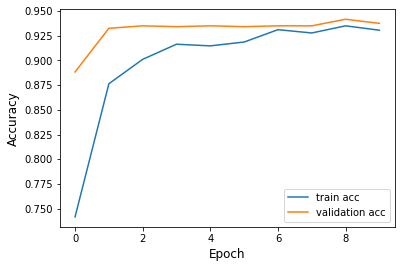

In [391]:
t_acc = Acc_train_list
v_acc = Acc_val_list

import matplotlib.pyplot as plt

x = [i for i in range(0,len(tloss))]

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.plot(x, t_acc, label="train acc")
plt.plot(x, v_acc, label="validation acc")

plt.tick_params(labelsize=10)
plt.legend(prop={"size": 10})

plt.show()

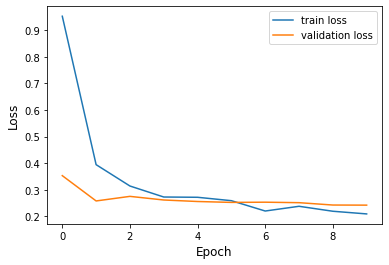

In [392]:
tloss = Train_loss
vloss = Val_loss

import matplotlib.pyplot as plt

x = [i for i in range(0,len(tloss))]

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.plot(x, tloss, label="train loss")
plt.plot(x, vloss, label="validation loss")

plt.tick_params(labelsize=10)
plt.legend(prop={"size": 10})

plt.show()

In [386]:
inputs_pre = torch.zeros(512)
inputs_pre = inputs_pre.cuda()

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [387]:
inputs_pre = torch.zeros(512)
inputs_pre = inputs_pre.cuda()

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from tqdm import tqdm

labels_numpy = 0
preds_numpy = 0

aa = []
bb = []

# テストデータでの正解率を求める
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained.eval()   # モデルを検証モードに
net_trained.to(device)  # GPUが使えるならGPUへ送る

# epochの正解数を記録する変数
epoch_corrects = 0

a = [[0, 0],
     [0, 0]]

for batch in tqdm(dl_test):  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    # GPUが使えるならGPUにデータを送る
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    inputs = batch.Text[0].to(device)  # 文章
    labels = batch.Label.to(device)  # ラベル



    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):

        # BertForReviewに入力
        outputs, weights = net_trained(inputs)

        loss = criterion(outputs, labels)  # 損失を計算
        _, preds = torch.max(outputs, 1)  # ラベルを予測
        epoch_corrects += torch.sum(preds == labels.data)  # 正解数の合計を更新

        labels_numpy = labels.cpu().numpy()
        preds_numpy = preds.cpu().numpy()

        aa = np.append(aa,labels_numpy)
        bb = np.append(bb,preds_numpy)



#間違えた要素を格納
        for i in range(0, len(preds)):
          if preds[i] != labels[i]:
            
            inputs_pre =  torch.cat([inputs_pre, inputs[i]], dim=0)

cm = confusion_matrix(aa, bb) # 混同行列(numpy.ndarray)の取得
print("コンフュージョンマトリックス")
print(cm)
# 正解率
epoch_acc = epoch_corrects.double() / len(dl_test.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), epoch_acc))

100%|██████████| 10/10 [00:21<00:00,  2.13s/it]

コンフュージョンマトリックス
[[542  45]
 [ 19 594]]
テストデータ1200個での正解率：0.9467


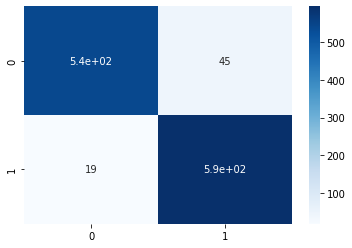

In [388]:
#テストデータでのコンフュージョンマトリクス
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, cmap='Blues')

In [403]:
# tsvファイルで保存する
#tr_df = tr_df[:100]
# 全体の2割の文章数
len_0_2 = len(tr_df) // 5

# 前から2割をテストデータとする
tr_df[:len_0_2].to_csv("./test.tsv", sep='\t', index=False, header=None)
print(tr_df[:len_0_2].shape)

# 前2割からを訓練&検証データとする
tr_df[len_0_2:].to_csv("./train.tsv", sep='\t', index=False, header=None)
print(tr_df[len_0_2:].shape)

def tokenizer_512(input_text):
    """torchtextのtokenizerとして扱えるように、512単語のpytorchでのencodeを定義。ここで[0]を指定し忘れないように"""
    return tokenizer.encode(input_text, max_length=512, return_tensors='pt')[0]


TEXT = torchtext.legacy.data.Field(sequential=True, tokenize=tokenizer_512, use_vocab=False, lower=False,include_lengths=True, batch_first=True, fix_length=512, pad_token=0)
# 注意：tokenize=tokenizer.encodeと、.encodeをつけます。padding[PAD]のindexが0なので、0を指定します。

#ラベルは数字なのでラベル用オブジェクトはsequential = False
LABEL = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

# 各tsvファイルを読み込み、分かち書きをしてdatasetにします
# 少し時間がかかります
# train_eval：4511個、test：1127個

dataset_train_eval, dataset_test = torchtext.legacy.data.TabularDataset.splits(
    path='.', train='train.tsv', test='test.tsv', format='tsv', fields=[('Text', TEXT), ('Label', LABEL)])

# torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
# train_eval：4000個、test：2000個

dataset_train, dataset_eval = dataset_train_eval.split(
    split_ratio = 1 - 0.25, random_state=random.seed(1234))

# datasetの長さを確認してみる
print(dataset_train.__len__())
print(dataset_eval.__len__())
print(dataset_test.__len__())

# 乱数シードの固定

import os
import random
import numpy as np
import torch

SEED_VALUE = 1234  # これはなんでも良い
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)  # PyTorchを使う場合

# torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
# train_eval：4000個、test：2000個

dataset_train, dataset_eval = dataset_train_eval.split(
    split_ratio = 1 - 0.25, random_state=random.seed(1234))

# datasetの長さを確認してみる
print(dataset_train.__len__())
print(dataset_eval.__len__())
print(dataset_test.__len__())

# datasetの中身を確認してみる
item = next(iter(dataset_train))
print(item.Text)
print("長さ：", len(item.Text))  # 長さを確認 [CLS]から始まり[SEP]で終わる。512より長いと後ろが切れる
print("ラベル：", item.Label)

(1200, 2)
(4800, 2)
3600
1200
1200
3600
1200
1200
tensor([    2,  8359,   235, 18177,  1285,    40,  8962,    48,   155,  7308,
            8,  6777,     9,   340, 28482, 28933, 28449,  4818,  2992,     8,
         3250,     9,  3038,    47, 28506,  2992,    14, 20505,     5,   120,
            9, 28285,    16,  2610,     8,  2449,  2638,    14,  3719,   947,
         3452,    28,   515,  2087,  2992,     8,  3225,     9,   427, 28781,
           18,   947,  5218, 28588,  5929,     9,  5735,    80,  2992,     8,
            3])
長さ： 61
ラベル： 0


In [404]:
# 乱数シードの固定

import os
import random
import numpy as np
import torch

SEED_VALUE = 1234  # これはなんでも良い
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE)  # PyTorchを使う場合

# torchtext.data.Datasetのsplit関数で訓練データと検証データを分ける
# train_eval：4000個、test：2000個

dataset_train, dataset_eval = dataset_train_eval.split(
    split_ratio = 1 - 0.25, random_state=random.seed(1234))

# datasetの長さを確認してみる
print(dataset_train.__len__())
print(dataset_eval.__len__())
print(dataset_test.__len__())

# datasetの中身を確認してみる
item = next(iter(dataset_train))
print(item.Text)
print("長さ：", len(item.Text))  # 長さを確認 [CLS]から始まり[SEP]で終わる。512より長いと後ろが切れる
print("ラベル：", item.Label)

# DataLoaderを作成

batch_size = 128

dl_train = torchtext.legacy.data.Iterator(
    dataset_train, batch_size=batch_size, train=True)

dl_eval = torchtext.legacy.data.Iterator(
    dataset_eval, batch_size=batch_size, train=False, sort=False)

dl_test = torchtext.legacy.data.Iterator(
    dataset_test, batch_size=batch_size, train=False, sort=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": dl_train, "val": dl_eval}

3600
1200
1200
tensor([    2,  8359,   235, 18177,  1285,    40,  8962,    48,   155,  7308,
            8,  6777,     9,   340, 28482, 28933, 28449,  4818,  2992,     8,
         3250,     9,  3038,    47, 28506,  2992,    14, 20505,     5,   120,
            9, 28285,    16,  2610,     8,  2449,  2638,    14,  3719,   947,
         3452,    28,   515,  2087,  2992,     8,  3225,     9,   427, 28781,
           18,   947,  5218, 28588,  5929,     9,  5735,    80,  2992,     8,
            3])
長さ： 61
ラベル： 0


In [405]:
from torch import nn


class BertForReview(nn.Module):
    '''BERTモデルにレビュー文の2クラスを判定する部分をつなげたモデル'''

    def __init__(self):
        super(BertForReview, self).__init__()

        # BERTモジュール
        self.bert = model  # 日本語学習済みのBERTモデル

        # headにポジネガ予測を追加
        # 入力はBERTの出力特徴量の次元768、出力は2クラス
        self.cls = nn.Linear(in_features=768, out_features=2)

        # 重み初期化処理
        nn.init.normal_(self.cls.weight, std=0.02)
        nn.init.normal_(self.cls.bias, 0)

    def forward(self, input_ids):
        '''
        input_ids： [batch_size, sequence_length]の文章の単語IDの羅列
        '''

        # BERTの基本モデル部分の順伝搬
        # 順伝搬させる
        result = self.bert(input_ids)  # reult は、sequence_output, pooled_output

        # sequence_outputの先頭の単語ベクトルを抜き出す
        vec_0 = result[0]  # 最初の0がsequence_outputを示す
        vec_0 = vec_0[:, 0, :]  # 全バッチ。先頭0番目の単語の全768要素
        vec_0 = vec_0.view(-1, 768)  # sizeを[batch_size, hidden_size]に変換
        output = self.cls(vec_0)  # 全結合層

        return output

#モデル構築
BERT_net2 = BertForReview()

# 訓練モードに設定
BERT_net2.train()

print('ネットワーク設定完了')

# 勾配計算を最後のBertLayerモジュールと追加した分類アダプターのみ実行

# 1. まず全部を、勾配計算Falseにしてしまう
for param in BERT_net2.parameters():
    param.requires_grad = False

# 2. BertLayerモジュールの最後を勾配計算ありに変更
for param in BERT_net2.bert.encoder.layer[-1].parameters():
    param.requires_grad = True

# 3. 識別器を勾配計算ありに変更
for param in BERT_net2.cls.parameters():
    param.requires_grad = True

ネットワーク設定完了


In [406]:
# 最適化手法の設定
import torch.optim as optim

# BERTの元の部分はファインチューニング
optimizer = optim.Adam([
    {'params': BERT_net2.bert.encoder.layer[-1].parameters(), 'lr': 6e-6},
    {'params': BERT_net2.cls.parameters(), 'lr': 1e-4}
])

# 損失関数の設定
criterion = nn.CrossEntropyLoss()
# nn.LogSoftmax()を計算してからnn.NLLLoss(negative log likelihood loss)を計算

In [407]:
# モデルを学習させる関数を作成

def train_model(bert_net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)
    print('-----start-------')
    # ネットワークをGPUへ
    #bert_net.to(device)
    bert_net.to(device)

    train_loss = []
    val_loss = []

    acc_train_list = []
    acc_val_list = []



    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # epochのループ
    for epoch in range(num_epochs):

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:

            if phase == 'train':
                bert_net.train()  # モデルを訓練モードに
                
            else:
                bert_net.eval()   # モデルを検証モードに


            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書オブジェクト

                # GPUが使えるならGPUにデータを送る
                inputs = batch.Text[0].to(device)  # 文章
                labels = batch.Label.to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()


                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):


                    # Transformerに入力
                    outputs  = bert_net(inputs)
                    
                    loss = criterion(outputs, labels)  # 損失を計算

                    _, preds = torch.max(outputs, 1)  # ラベルを予測（dim=1 列方向のＭａｘを取得、predsは最大のindex）

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()   #損失の計算
                        optimizer.step()  # 勾配の更新


                    # 結果の計算
                    epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            if phase == 'train':
              train_loss = np.append(train_loss, epoch_loss)
              acc_train_list = np.append(acc_train_list, epoch_acc.cpu().numpy())

            else:
              val_loss = np.append(val_loss, epoch_loss)
              acc_val_list = np.append(acc_val_list, epoch_acc.cpu().numpy())

            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc))


    return bert_net, train_loss, val_loss, acc_train_list, acc_val_list


In [408]:
# 学習・検証を実行
num_epochs = 10
net_trained2, Train_loss, Val_loss, Acc_train_list, Acc_val_list = train_model(BERT_net2, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
-----start-------
Epoch 1/10 | train |  Loss: 0.5062 Acc: 0.7558
Epoch 1/10 |  val  |  Loss: 0.3094 Acc: 0.8817
Epoch 2/10 | train |  Loss: 0.2785 Acc: 0.9175
Epoch 2/10 |  val  |  Loss: 0.2008 Acc: 0.9283
Epoch 3/10 | train |  Loss: 0.2109 Acc: 0.9261
Epoch 3/10 |  val  |  Loss: 0.1821 Acc: 0.9308
Epoch 4/10 | train |  Loss: 0.1852 Acc: 0.9317
Epoch 4/10 |  val  |  Loss: 0.1809 Acc: 0.9317
Epoch 5/10 | train |  Loss: 0.1729 Acc: 0.9361
Epoch 5/10 |  val  |  Loss: 0.1828 Acc: 0.9300
Epoch 6/10 | train |  Loss: 0.1718 Acc: 0.9347
Epoch 6/10 |  val  |  Loss: 0.1775 Acc: 0.9308
Epoch 7/10 | train |  Loss: 0.1597 Acc: 0.9392
Epoch 7/10 |  val  |  Loss: 0.1919 Acc: 0.9258
Epoch 8/10 | train |  Loss: 0.1584 Acc: 0.9378
Epoch 8/10 |  val  |  Loss: 0.1951 Acc: 0.9275
Epoch 9/10 | train |  Loss: 0.1543 Acc: 0.9375
Epoch 9/10 |  val  |  Loss: 0.1853 Acc: 0.9358
Epoch 10/10 | train |  Loss: 0.1570 Acc: 0.9386
Epoch 10/10 |  val  |  Loss: 0.1823 Acc: 0.9333


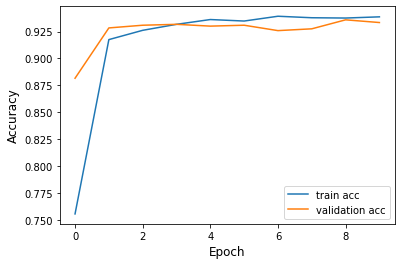

In [409]:
t_acc2 = Acc_train_list
v_acc2 = Acc_val_list

import matplotlib.pyplot as plt

x = [i for i in range(0,len(tloss))]

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.plot(x, t_acc2, label="train acc")
plt.plot(x, v_acc2, label="validation acc")

plt.tick_params(labelsize=10)
plt.legend(prop={"size": 10})

plt.show()

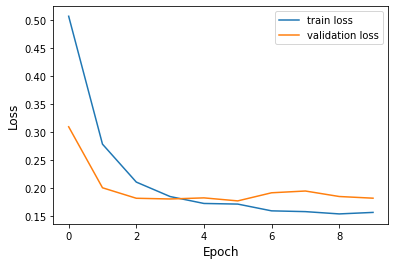

In [410]:
tloss2 = Train_loss
vloss2 = Val_loss

import matplotlib.pyplot as plt

x = [i for i in range(0,len(tloss))]

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.plot(x, tloss2, label="train loss")
plt.plot(x, vloss2, label="validation loss")

plt.tick_params(labelsize=10)
plt.legend(prop={"size": 10})

plt.show()

In [411]:
inputs_pre = torch.zeros(512)
inputs_pre = inputs_pre.cuda()

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from tqdm import tqdm

labels_numpy = 0
preds_numpy = 0

aa = []
bb = []

# テストデータでの正解率を求める
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_trained.eval()   # モデルを検証モードに
net_trained.to(device)  # GPUが使えるならGPUへ送る

# epochの正解数を記録する変数
epoch_corrects = 0

a = [[0, 0],
     [0, 0]]

for batch in tqdm(dl_test):  # testデータのDataLoader
    # batchはTextとLableの辞書オブジェクト
    # GPUが使えるならGPUにデータを送る
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    inputs = batch.Text[0].to(device)  # 文章
    labels = batch.Label.to(device)  # ラベル



    # 順伝搬（forward）計算
    with torch.set_grad_enabled(False):

        # BertForReviewに入力
        outputs = net_trained(inputs)

        loss = criterion(outputs, labels)  # 損失を計算
        _, preds = torch.max(outputs, 1)  # ラベルを予測
        epoch_corrects += torch.sum(preds == labels.data)  # 正解数の合計を更新

        labels_numpy = labels.cpu().numpy()
        preds_numpy = preds.cpu().numpy()

        aa = np.append(aa,labels_numpy)
        bb = np.append(bb,preds_numpy)



#間違えた要素を格納
        for i in range(0, len(preds)):
          if preds[i] != labels[i]:
            
            inputs_pre =  torch.cat([inputs_pre, inputs[i]], dim=0)

cm = confusion_matrix(aa, bb) # 混同行列(numpy.ndarray)の取得
print("コンフュージョンマトリックス")
print(cm)
# 正解率
epoch_acc = epoch_corrects.double() / len(dl_test.dataset)

print('テストデータ{}個での正解率：{:.4f}'.format(len(dl_test.dataset), epoch_acc))

100%|██████████| 10/10 [00:20<00:00,  2.09s/it]

コンフュージョンマトリックス
[[561  26]
 [ 24 589]]
テストデータ1200個での正解率：0.9583


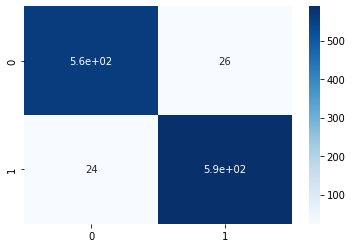

In [412]:
#テストデータでのコンフュージョンマトリクス
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, cmap='Blues')